# Multitask Learning

Use a single shared representation to predict gender and phase 2

### Load Embeddings and Abstracts

In [32]:
%store -r embeddings_info

abstracts = embeddings_info['abstracts']
abstracts_padded = embeddings_info['abstracts_padded']
embeddings = embeddings_info['embeddings']
word_dim = embeddings_info['word_dim']
word2idx, idx2word = embeddings_info['word2idx'], embeddings_info['idx2word']
maxlen = embeddings_info['maxlen']
vocab_size = embeddings_info['vocab_size']

### Load Labels

In [33]:
%store -r pruned_dataset binarized_dataset

ys = np.array(binarized_dataset).T

from support import classinfo_generator

labels = pruned_dataset.columns.tolist()
class_info = list(classinfo_generator(pruned_dataset))
class_names, class_sizes = zip(*class_info)
class_names = {label: classes for label, classes in zip(labels, class_names)}

### Train - Validation Split

In [37]:
from sklearn.cross_validation import KFold

fold = KFold(len(abstracts_padded), n_folds=5, shuffle=True)
p = iter(fold)

train_idxs, val_idxs = next(p)
val_idxs = train_idxs # HARD-CODE VALIDATION SET TO TRAINING SET FOR NOW!!!

X_train, ys_train = abstracts_padded[train_idxs], ys[:, train_idxs]
X_val, ys_val = abstracts_padded[val_idxs], ys[:, val_idxs]

num_train, num_val = len(X_train), len(X_val)

val_dict = {label: y_row for label, y_row in zip(labels, ys_val)}

### Hyperparameters

In [40]:
nb_filter = 20
filter_length = 2
hidden_dims = 32
nb_epoch = 35
batch_size = 10

### Define Model

In [41]:
from keras.models import Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D

model = Graph()
model.add_input(name='input', input_shape=[maxlen], dtype='int') # dtype='int' is 100% necessary for some reason!
model.add_node(Embedding(input_dim=vocab_size, output_dim=word_dim, weights=[embeddings], input_length=maxlen, trainable=False),
               name='embedding', input='input')
model.add_node(Dropout(0.25), name='dropout1', input='embedding')

model.add_node(Convolution1D(nb_filter=nb_filter,
                             filter_length=filter_length,
                             activation='relu'),
              name='conv',
              input='dropout1')
model.add_node(MaxPooling1D(pool_length=maxlen-1), name='pool', input='conv') # non-maximum suppression
model.add_node(Flatten(), name='flat', input='pool')
model.add_node(Dense(hidden_dims), name='z', input='flat')
model.add_node(Activation('relu'), name='shared', input='z')
model.add_node(Dropout(0.25), name='dropout2', input='shared')

# Fork the graph and predict probabilities for each target from shared representation
for label, num_classes in zip(labels, class_sizes):
    model.add_node(Dense(output_dim=num_classes, activation='softmax'), name='{}_probs'.format(label), input='dropout2')
    model.add_output(name=label, input='{}_probs'.format(label))

model.compile(optimizer='rmsprop',
              loss={label: 'categorical_crossentropy' for label in labels}) # CE for all the targets

### Random Minibatch Generator

In [42]:
def batch_generator(ys, batch_size, balanced=True):
    """Yield successive batches for training
    
    This generator is not meant to be exhausted, but rather called by next().
    
    Each batch has batch_size/num_classes number of examples from each class
    
    """
    num_objectives, num_train = ys.shape
    
    while True:
        yield np.random.choice(num_train, size=batch_size)

### Minibatch Training

In [43]:
batch_size = num_train // 2

train_batch = batch_generator(ys_train, batch_size)

In [45]:
from support import produce_labels

for i in range(100):
    batch_idxs = next(train_batch)
    
    X = X_train[batch_idxs]
    train_dict = dict(produce_labels(labels, class_sizes, ys_train[:, batch_idxs]))
    train_dict.update({'input': X})

    train_error = model.train_on_batch(train_dict)

    if not i % 10:
        print train_error
        
        predictions = model.predict({'input': X_val})
        for label, ys_pred in predictions.items():
            print '{} accuracy:'.format(label), np.mean(ys_pred.argmax(axis=1) == val_dict[label])

[array(0.7199770212173462, dtype=float32)]
gender accuracy: 0.6875
phase_2 accuracy: 1.0
[array(0.7814040184020996, dtype=float32)]
gender accuracy: 0.6875
phase_2 accuracy: 1.0
[array(0.8557045459747314, dtype=float32)]
gender accuracy: 0.75
phase_2 accuracy: 1.0
[array(0.4954754710197449, dtype=float32)]
gender accuracy: 0.75
phase_2 accuracy: 1.0
[array(0.5447196960449219, dtype=float32)]
gender accuracy: 0.875
phase_2 accuracy: 1.0
[array(0.9085276126861572, dtype=float32)]
gender accuracy: 0.875
phase_2 accuracy: 1.0
[array(0.6383398771286011, dtype=float32)]
gender accuracy: 0.9375
phase_2 accuracy: 1.0
[array(0.36813780665397644, dtype=float32)]
gender accuracy: 0.9375
phase_2 accuracy: 1.0
[array(0.4402334690093994, dtype=float32)]
gender accuracy: 0.9375
phase_2 accuracy: 1.0
[array(0.6036130785942078, dtype=float32)]
gender accuracy: 1.0
phase_2 accuracy: 1.0


### Confusion Matrix

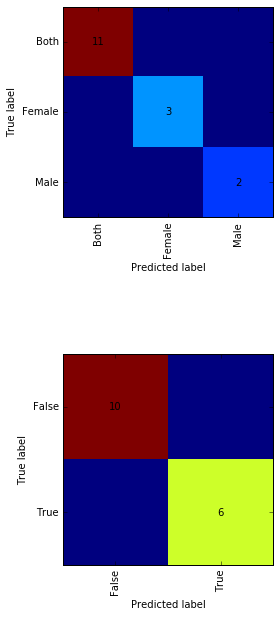

In [54]:
from sklearn.metrics import confusion_matrix
from support import plot_confusion_matrix

predictions = model.predict({'input': X_val})

fig = plt.figure(figsize=(10,10))
plt.clf()

for i, [(label, ys_pred), y_row] in enumerate(zip(predictions.items(), ys_val), start=1):
    axes = fig.add_subplot(2, 1, i)
    
    cm = confusion_matrix(y_row, ys_pred.argmax(axis=1))
    plot_confusion_matrix(cm, class_names[label])
    
    fig.subplots_adjust(wspace=.35, hspace=.65)

### Examine Bigrams Which Filters Fire on

In [73]:
filters = model.nodes['conv'].W.eval()
filters = np.squeeze(filters)
filters = [filter.T for filter in filters]

def activation_generator(filter, abstract):
    for w1, w2 in zip(abstract, abstract[1:]):
        yield np.sum(embeddings[[w1, w2]] * filter), (w1, w2)
        
def activations_generator(filters, abstract):
    for filter in filters:
        yield list(activation_generator(filter, abstract))
        
def show_activations(filters, abstract):
    activations = list(activations_generator(filters, abstract))

    for activation in activations:
        for score, (w1, w2) in sorted(activation, reverse=True)[:10]:
            print score, idx2word[w1], idx2word[w2]

        print

for idx in [0, 2, 7, 9, 10]:
    print abstracts[idx]
    print
    for label, symbol in zip(labels, ys[:, idx]):
        print label, class_names[label][symbol]
    print
    
    show_activations(filters, abstracts_padded[idx])

D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. 
                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. 
                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. 
                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo treatment on any primary outcome mea